<a href="https://colab.research.google.com/github/SiboneloJunior/AI4D-Predict-the-Global-Spread-of-COVID-19/blob/master/SJMalakiya_AI4D_Zindi_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Importing packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from math import sqrt

# Introduction

##### **Problem Statement**

The objective of this challenge is to build an epidemiological model that predicts the spread of COVID-19 throughout the world. The target variable is the cumulative number of deaths caused by COVID-19 in each country by each date.


##### **Logic Behind The Linear Model**

The typical growth curve of any epidemic a follows logistic curve with 3 phases
- Slow/Flat Start
- Exponential Growth
- Flatting Curve ( Virus runs out of new victims )

However to fit a linear model , We need to intellegently modify the curve to approximate a linear curve...this is illustrated below

Fitting Linear Model on a Natural Logistic Curve


![alt text](https://drive.google.com/uc?id=1g5tw5pzv7kyLCa3y_611t89OT8XzDGbH)


Fitting Linear model on a Pre-Processed Logistic curve ( All rows where cases == 0 removed )

![alt text](https://drive.google.com/uc?id=1TwE-jHGW-9V8huyKXLkwOp-xg9EOScah)


Hence The Spread/Growth of the Covid-19 Virus can be approximated with a linear fit performed in such manner


*   Use Day Count vs Cases on the training dataset to find the linear coefficients Per country
*   Use those linear coefficients to predict cases for any given day ( Thus can be extended to June for the competition )
*   Furthermore use ( Day Count + Cases ) vs Target to fit a multivariable linear model, hence calculating the coefficents and intercepts of the model
*    Then use the first coefficients to predict 'cases per date' on the given submission file , then using the predicted cases + day count , use the second coefficients + intercepts to predict the target variable.


Note : These steps are also re-iterated on code blocks for further clarity







# Importing Datasets




*   Training dataset was generated from Covid-19-Data-Prep.ipynb Notebook ( Found on the Repository )
*   The set contains data from 22 January to 17 April 2020( Latest available data provided by Zindi )



In [37]:
# Training dataset imported directly from GitHub Repo

df_train = pd.read_csv('https://raw.githubusercontent.com/SiboneloJunior/AI4D-Predict-the-Global-Spread-of-COVID-19/master/Data/train_04_17.csv')
df_train.head()

,Territory X Date,target,cases,Territory,Date
0,Afghanistan X 1/22/20,0,0,Afghanistan,1/22/20
1,Afghanistan X 1/23/20,0,0,Afghanistan,1/23/20
2,Afghanistan X 1/24/20,0,0,Afghanistan,1/24/20
3,Afghanistan X 1/25/20,0,0,Afghanistan,1/25/20
4,Afghanistan X 1/26/20,0,0,Afghanistan,1/26/20


# Pre-Processing

Step by Step Process

*   Remove rows where Cases == 0
   - The Slow exponential start is thus avoided , and a Linear model can be reasonably fit


*   Convert Date into Day Count from First Case
*   Append Day count to original dataframe

In [0]:
# Remove all cases == 0

no_zeros = df_train.drop_duplicates(
            subset=['cases', 'Territory'], keep= 'first')

In [0]:
# Convert Dates into Day count

master_day_list = []
country_list = sorted(list(set(no_zeros['Territory'])))
for country in country_list :

    r = no_zeros[no_zeros['Territory'] == country ]
    r_dates = list(r['Date'])

    y = range(len(r) + 1)
    o = list(y)
    h = o[1:]
    day_list = h
    
    master_day_list.append(day_list)

In [0]:
# Flatten the list

flat_list = [item for sublist in master_day_list for item in sublist]

In [41]:
# Append the flat list on modified dataframe

no_zeros['Day'] = flat_list

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
# Dropping columns not useful for the model

df_model = no_zeros
df_model = df_model.drop(['Territory X Date', 'Date'], axis=1)
df_model.head()

,target,cases,Territory,Day
0,0,0,Afghanistan,1
33,0,1,Afghanistan,2
46,0,4,Afghanistan,3
48,0,5,Afghanistan,4
49,0,7,Afghanistan,5


# Visualisations



*   Plots to understand the general behaivour ( Done only for Belgium)
*   The benefits of removing cases == 0  is now evident and  Linear Model can be fit






/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


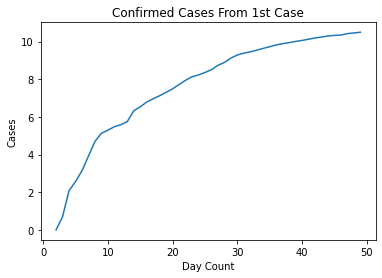

In [43]:
# Generate Plot

df_plot = df_model[df_model['Territory'] == 'Belgium']
x = list(df_plot['Day'])
y = list(df_plot['cases'])
y1 = np.log(list(df_plot['cases']))
plt.plot(x,y1)
plt.xlabel('Day Count')
plt.ylabel('Cases')
plt.title('Confirmed Cases From 1st Case')
plt.show()

# Model Building

Step by Step Process



*   Create Country list
*   Fit Linear model to 'Day Count' & 'Cases'
  - This will produce Linear Coefficients to be utilised later
  - General equation is y = ax

*   Map the Coefficients to the original dataframe
*   Fit Linear model to to produce Coefficients and y-intercept for the target variable 
    - X_features > Day count + Cases
    - y > Target
    - General equation is y = ax + bx + c

Note : First Linear fit will have one coefficient per country ( Linear_vars ) , and Second fit will have two coefficients + Intercept per country ( Linear_vars_2 )

See dataframes below







In [0]:
# Create Country list

country_list = list(set(df_model['Territory']))

In [0]:
# linear regression - generate coefficients

linear_var = []

for country in country_list :
    df_country = df_model[df_model['Territory']==country]         
    x_data = np.array(df_country['Day']).reshape(-1,1)
    y_data = np.array(df_country['cases'])
    
    L = LinearRegression()
    L.fit(x_data, y_data)

    Coeff = L.coef_
    linear_var.append(Coeff)    

In [0]:
# Creating dictionaries for mapping                    

linear_dict = dict(zip(country_list, linear_var))

In [0]:
# Append Linear variables to original dataset

df_linear = df_model.copy()
df_linear['linear_vars'] = df_linear['Territory'].map(linear_dict) 

In [48]:
df_linear.head()

,target,cases,Territory,Day,linear_vars
0,0,0,Afghanistan,1,[25.791316526610643]
33,0,1,Afghanistan,2,[25.791316526610643]
46,0,4,Afghanistan,3,[25.791316526610643]
48,0,5,Afghanistan,4,[25.791316526610643]
49,0,7,Afghanistan,5,[25.791316526610643]


In [0]:
# Fit Original Cases and Target variable to a Linear model 
# Save coefficients and intercepts of the model

coeff_list_linear = []
intercept_list_linear = []
country_list = list(set(df_linear['Territory']))

for the_country in country_list :
    df_cc = df_linear[df_linear['Territory'] == the_country ]
    df_cb = df_cc.drop(['Territory', 'linear_vars'], axis=1)

    X = df_cb.drop('target', axis = 1).values
    y = df_cb['target']

    L = LinearRegression()
    L.fit(X, y)

    Coeff = L.coef_
    coeff_list_linear.append(Coeff)

    intercept = L.intercept_
    intercept_list_linear.append(intercept)                              

In [0]:
# Creating dictionaries for mapping                    

coeff_dict_linear = dict(zip(country_list, coeff_list_linear))
intercept_dict_linear = dict(zip(country_list,intercept_list_linear ))

In [51]:
# Visualise th dataframe with new generated columns

df_linear['linear_vars_2'] = df_linear['Territory'].map(coeff_dict_linear)
df_linear['intercepts'] = df_linear['Territory'].map(intercept_dict_linear)
df_linear.head()

,target,cases,Territory,Day,linear_vars,linear_vars_2,intercepts
0,0,0,Afghanistan,1,[25.791316526610643],"[0.04036279490419757, -0.20935695820840075]",0.780753
33,0,1,Afghanistan,2,[25.791316526610643],"[0.04036279490419757, -0.20935695820840075]",0.780753
46,0,4,Afghanistan,3,[25.791316526610643],"[0.04036279490419757, -0.20935695820840075]",0.780753
48,0,5,Afghanistan,4,[25.791316526610643],"[0.04036279490419757, -0.20935695820840075]",0.780753
49,0,7,Afghanistan,5,[25.791316526610643],"[0.04036279490419757, -0.20935695820840075]",0.780753


# Preparing submission file

Step by Step Process

*   Importing and Pre-Processing the submission file
*   Append Linear_vars ( Generated from Train ) to the data
    - This will make it possible to predict the Cases till June , Using Day Count + Coefficients in a linear model

*   Append Linear_vars_2 to the data
    - Using the cases we just calculated + Coefficients and intercepts of Linear_var_2 , The target variable is predicted
*   Closing Pre-processing is done to get the CSV file in the format required to make a valid Zindi submission








In [52]:
# Quick pre-processing
# Getting Territory and Date from 'Territory X Date'

df_sub = pd.read_csv('https://raw.githubusercontent.com/SiboneloJunior/AI4D-Predict-the-Global-Spread-of-COVID-19/master/Data/SampleSubmission.csv')
df_sub['Territory'] = df_sub[
                      'Territory X Date'].apply(lambda x: x.split(' X ')[0])
df_sub['Date'] = df_sub['Territory X Date'].apply(lambda x: x.split(' X ')[1])
df_sub.head()

,Territory X Date,target,Territory,Date
0,Afghanistan X 03/06/20,0,Afghanistan,03/06/20
1,Afghanistan X 03/07/20,0,Afghanistan,03/07/20
2,Afghanistan X 03/08/20,0,Afghanistan,03/08/20
3,Afghanistan X 03/09/20,0,Afghanistan,03/09/20
4,Afghanistan X 03/10/20,0,Afghanistan,03/10/20


In [53]:
# Converting the Date into Day count

r = df_sub[df_sub['Territory'] == 'Afghanistan']
r_dates = list(r['Date'])

y = range(95)
o = list(y)
h = o[1:]
day_list = h

day_dict = dict(zip(r_dates, day_list))

df_sub['Day'] = df_sub['Date'].map(day_dict)
df_sub.head()

,Territory X Date,target,Territory,Date,Day
0,Afghanistan X 03/06/20,0,Afghanistan,03/06/20,1
1,Afghanistan X 03/07/20,0,Afghanistan,03/07/20,2
2,Afghanistan X 03/08/20,0,Afghanistan,03/08/20,3
3,Afghanistan X 03/09/20,0,Afghanistan,03/09/20,4
4,Afghanistan X 03/10/20,0,Afghanistan,03/10/20,5


In [0]:
# Append linear coefficients for each country ( Linear_vars )

df_sub['linear_vars'] = df_sub['Territory'].map(linear_dict)

In [0]:
# Predict cases using co-efficients generated from the train data


day = list(df_sub['Day'])
all_vars = list(df_sub['linear_vars'])
predictions_cases_lower = []
count_day = 0

for var in all_vars :
    a = var[0]
    pred_cases = a*day[count_day]
    predictions_cases_lower.append(pred_cases)
    count_day = count_day + 1

In [0]:
# Map the predictions of Re-predicted cases to the latest dataframe

df_sub['predictions_cases'] = predictions_cases_lower

In [0]:
# Map Linear_var_2 coefficients generated from training dataset

df_sub['coeff'] = df_sub['Territory'].map(coeff_dict_linear)
df_sub['intercept'] = df_sub['Territory'].map(intercept_dict_linear)

In [0]:
# Predicting the target till june
# Using Predicted Cases & Coefficients

pred_target_lower = []
day = list(df_sub['Day'])
list_pred_cases = list(df_sub['predictions_cases'])
list_coeff = list(df_sub['coeff'])
list_intercept = list(df_sub['intercept'])
another_count = 0

for inter in list_intercept :
    y_coeff = list_coeff[another_count]
    predictions_target = inter + ( y_coeff[0]* list_pred_cases[another_count]
                                  ) + (y_coeff[1] * day[another_count])
    pred_target_lower.append(predictions_target)
    another_count = another_count + 1

In [59]:
# Populate target variable with values ( Making Prediction)

df_sub['target'] = pred_target_lower
df_sub.head()

,Territory X Date,target,Territory,Date,Day,linear_vars,predictions_cases,coeff,intercept
0,Afghanistan X 03/06/20,1.612405,Afghanistan,03/06/20,1,[25.791316526610643],25.791317,"[0.04036279490419757, -0.20935695820840075]",0.780753
1,Afghanistan X 03/07/20,2.444058,Afghanistan,03/07/20,2,[25.791316526610643],51.582633,"[0.04036279490419757, -0.20935695820840075]",0.780753
2,Afghanistan X 03/08/20,3.275711,Afghanistan,03/08/20,3,[25.791316526610643],77.373950,"[0.04036279490419757, -0.20935695820840075]",0.780753
3,Afghanistan X 03/09/20,4.107363,Afghanistan,03/09/20,4,[25.791316526610643],103.165266,"[0.04036279490419757, -0.20935695820840075]",0.780753
4,Afghanistan X 03/10/20,4.939016,Afghanistan,03/10/20,5,[25.791316526610643],128.956583,"[0.04036279490419757, -0.20935695820840075]",0.780753


In [0]:
# Remove leading zero's from the date column
# Inline with Zindi submission

new_dates = []
date = list(df_sub['Date'])
leading_removed = [s.lstrip("0") for s in date]
for i in leading_removed :
    t = i[2:4]
    if t[0] == '0' :
        a = i[0:2] + t[1] + i[4:]
        new_dates.append(a)
    else :
        new_dates.append(i)

df_sub['Date'] = new_dates

In [0]:
# Convert target variable from float to int

intergers_list = []
floats = list(df_sub['target'])
for num in floats :
    interger = int(num)
    intergers_list.append(interger)


In [0]:
# Create a Dataframe with format Territory X Date

df_without_zeros = df_sub['Territory'] + ' X ' + df_sub['Date']

In [0]:
# Replace with date thus omitting leading zero

df_sub['Territory X Date'] = df_without_zeros

In [0]:
# Replace with int type target

df_sub['target'] = intergers_list

In [0]:
# Drop all Unused columns

df_submission = df_sub.drop(['Territory','Date','Day',
                             'linear_vars' ,'predictions_cases',
                             'coeff','intercept'], axis=1)

In [66]:
# Confirm dtypes

df_submission.dtypes

Territory X Date    object
target               int64
dtype: object

In [0]:
# To CSV ( Using Colab )

from google.colab import files

df_submission.to_csv('modelv2.18.csv' , index = False) 
files.download('modelv2.18.csv')